# Extended EDA for E-commerce Search Sessions (Learning-to-Rank)

This notebook is a **complete, extended EDA** for the `search_sessions.csv` dataset used in the Learning-to-Rank task.

It focuses on:
- data quality & missingness
- session-level analysis (group = `session_id`)
- position bias (overall + conditional)
- click behavior diagnostics
- feature gaps and high-impact feature engineering ideas for LTR
- baseline rankers & offline metrics (NDCG@5)

**Input expected:** `search_sessions.csv` in the same directory as this notebook.


In [1]:
# If running locally: pip install pandas numpy matplotlib scikit-learn
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

DATA_PATH = "search_sessions.csv"
assert os.path.exists(DATA_PATH), f"Missing file: {DATA_PATH}. Put it next to this notebook."
df = pd.read_csv(DATA_PATH)

df.head()

,session_id,product_id,position,clicked,price_pln,category,quality_score,user_preferred_category
0,0,prod_0_1,1,1,40.05,Elektronika,0.363,Elektronika
1,0,prod_0_2,2,0,249.63,Elektronika,0.547,Elektronika
2,0,prod_0_3,3,0,679.19,Elektronika,0.696,Elektronika
3,0,prod_0_4,4,0,493.38,Elektronika,0.100,Elektronika
4,0,prod_0_5,5,0,2982.39,Odziez,0.384,Elektronika


## 1) Dataset overview

In [2]:
print("Shape:", df.shape)
print("\nDtypes:")
display(df.dtypes)

print("\nBasic stats (numeric):")
display(df.describe(include=[np.number]).T)

print("\nUnique counts:")
display(df.nunique().to_frame("nunique").T)

Shape: (67651, 8)

Dtypes:


session_id                   int64
product_id                  object
position                     int64
clicked                      int64
price_pln                  float64
category                    object
quality_score              float64
user_preferred_category     object
dtype: object


Basic stats (numeric):


,count,mean,std,min,25%,50%,75%,max
session_id,67651.0,4001.188674,2307.732177,0.00,2002.000,4017.000,5993.000,7999.000
position,67651.0,5.035062,2.896451,1.00,3.000,5.000,7.000,12.000
clicked,67651.0,0.076732,0.266168,0.00,0.000,0.000,0.000,1.000
price_pln,67651.0,366.613191,400.741626,5.54,133.470,244.840,449.965,8184.250
quality_score,67651.0,0.501738,0.222478,0.10,0.327,0.501,0.677,0.999



Unique counts:


,session_id,product_id,position,clicked,price_pln,category,quality_score,user_preferred_category
nunique,8000,67651,12,2,43708,3,899,3


### 1.1 Missing values & obvious data quality checks

In [3]:
missing = df.isna().mean().sort_values(ascending=False)
display((missing * 100).to_frame("% missing").head(50))

# Basic sanity checks
checks = {
    "clicked in {0,1}": df["clicked"].dropna().isin([0,1]).all(),
    "position in [1,10] (if expected)": df["position"].dropna().between(1, 10).all(),
    "quality_score in [0,1]": df["quality_score"].dropna().between(0, 1).all(),
    "price_pln >= 0": (df["price_pln"].dropna() >= 0).all(),
}
display(pd.DataFrame([checks]))

,% missing
session_id,0.0
product_id,0.0
position,0.0
clicked,0.0
price_pln,0.0
category,0.0
quality_score,0.0
user_preferred_category,0.0


,"clicked in {0,1}","position in [1,10] (if expected)","quality_score in [0,1]",price_pln >= 0
0,True,False,True,True


### 1.2 Duplicates & integrity (session_id, product_id)

In [4]:
dup = df.duplicated(subset=["session_id", "product_id"]).mean()
print("Duplicate rate for (session_id, product_id):", dup)

if dup > 0:
    display(df[df.duplicated(subset=["session_id","product_id"], keep=False)].sort_values(["session_id","product_id"]).head(50))

Duplicate rate for (session_id, product_id): 0.0


## 2) Core target metrics (CTR, position bias, category CTR)

In [5]:
def ctr(sub):
    if len(sub) == 0:
        return np.nan
    return float(sub["clicked"].mean())

overall_ctr = ctr(df)

ctr_pos = df.groupby("position")["clicked"].mean().sort_index()
ctr_pos1 = float(ctr_pos.loc[1]) if 1 in ctr_pos.index else np.nan
ctr_pos5 = float(ctr_pos.loc[5]) if 5 in ctr_pos.index else np.nan
position_bias_ratio = (ctr_pos1 / max(ctr_pos5, 1e-12)) if pd.notna(ctr_pos1) and pd.notna(ctr_pos5) else np.nan

electronics_ctr = ctr(df[df["category"] == "Elektronika"]) if "category" in df.columns else np.nan

quality_corr = df["quality_score"].astype(float).corr(df["clicked"].astype(float), method="pearson")
quality_corr = 0.0 if pd.isna(quality_corr) else float(quality_corr)

ctr_by_cat = df.groupby("category")["clicked"].mean().sort_values(ascending=False)
best_category = ctr_by_cat.index[0] if len(ctr_by_cat) else None

summary = {
    "overall_ctr": overall_ctr,
    "position_bias_ratio": position_bias_ratio,
    "electronics_ctr": electronics_ctr,
    "quality_correlation_pearson": quality_corr,
    "best_category": best_category,
}
display(pd.DataFrame([summary]))

print("\nCTR by category:")
display(ctr_by_cat.to_frame("CTR"))

,overall_ctr,position_bias_ratio,electronics_ctr,quality_correlation_pearson,best_category
0,0.076732,3.424569,0.121921,0.11985,Elektronika



CTR by category:


,CTR
category,
Elektronika,0.121921
Odziez,0.070694
Ksiazki,0.036991


### 2.1 Visual: CTR vs position

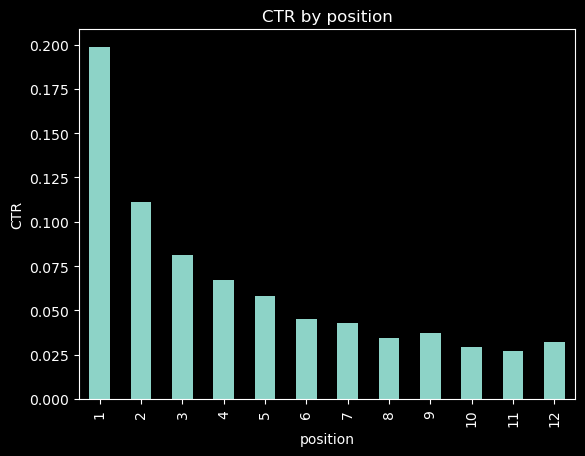

In [6]:
plt.figure()
ctr_pos.plot(kind="bar")
plt.title("CTR by position")
plt.xlabel("position")
plt.ylabel("CTR")
plt.show()

## 3) Session-level analysis (critical for LTR)

Sessions: 8000


,session_size
count,8000.000000
mean,8.456375
std,2.278321
min,5.000000
25%,6.000000
50%,8.000000
75%,10.000000
max,12.000000


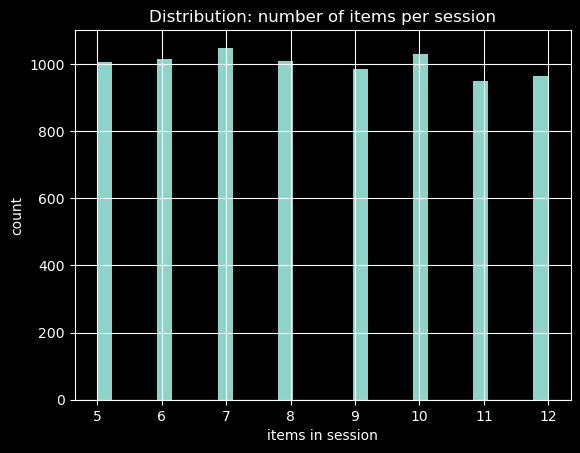

,clicks_per_session
count,8000.000000
mean,0.648875
std,0.804156
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,6.000000


Share sessions with 0 clicks: 0.523125
Share sessions with 1 click: 0.3375
Share sessions with >=2 clicks: 0.139375


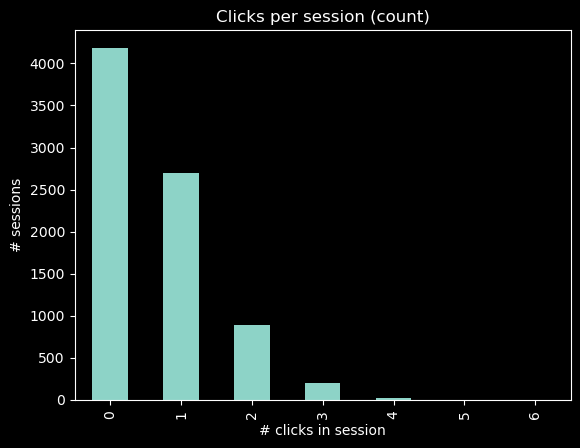

In [7]:
# Session size (how many candidate products per session)
session_size = df.groupby("session_id").size()
print("Sessions:", session_size.shape[0])
display(session_size.describe().to_frame("session_size"))

plt.figure()
session_size.hist(bins=30)
plt.title("Distribution: number of items per session")
plt.xlabel("items in session")
plt.ylabel("count")
plt.show()

# Clicks per session
clicks_per_session = df.groupby("session_id")["clicked"].sum()
display(clicks_per_session.describe().to_frame("clicks_per_session"))

share_no_click = float((clicks_per_session == 0).mean())
share_one_click = float((clicks_per_session == 1).mean())
share_ge2 = float((clicks_per_session >= 2).mean())
print("Share sessions with 0 clicks:", share_no_click)
print("Share sessions with 1 click:", share_one_click)
print("Share sessions with >=2 clicks:", share_ge2)

plt.figure()
clicks_per_session.value_counts().sort_index().plot(kind="bar")
plt.title("Clicks per session (count)")
plt.xlabel("# clicks in session")
plt.ylabel("# sessions")
plt.show()

### 3.1 Where do clicks happen? (clicked position distribution)

,clicked_count
position,
1,1589
2,888
3,652
4,539
5,464
6,317
7,255
8,170
9,147


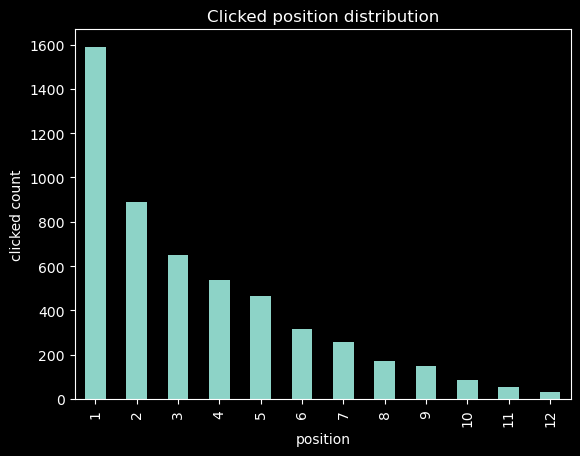

Median clicked position: 3.0
Mean clicked position: 3.4638797919476016


In [8]:
clicked_rows = df[df["clicked"] == 1].copy()
clicked_pos = clicked_rows["position"].value_counts().sort_index()

display(clicked_pos.to_frame("clicked_count"))

plt.figure()
clicked_pos.plot(kind="bar")
plt.title("Clicked position distribution")
plt.xlabel("position")
plt.ylabel("clicked count")
plt.show()

# Median clicked position
if len(clicked_rows):
    print("Median clicked position:", float(clicked_rows["position"].median()))
    print("Mean clicked position:", float(clicked_rows["position"].mean()))

## 4) Conditional position bias (bias is rarely uniform)

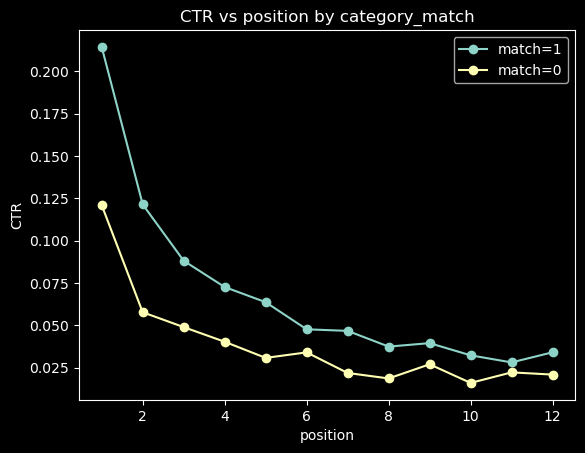

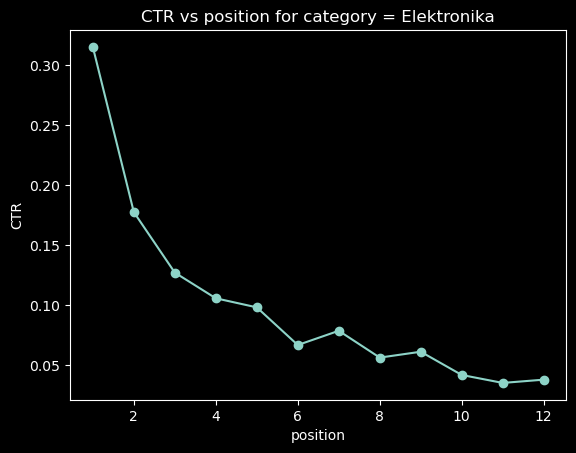

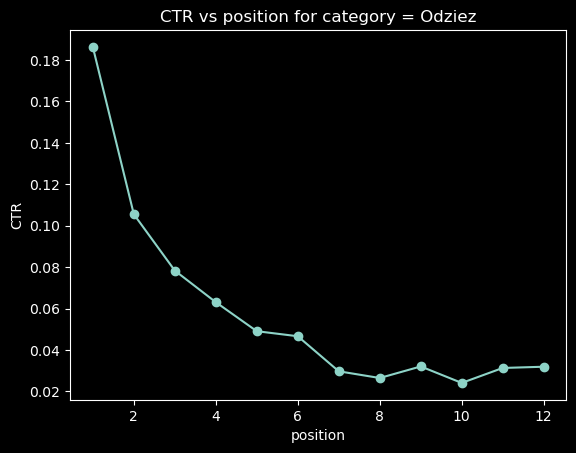

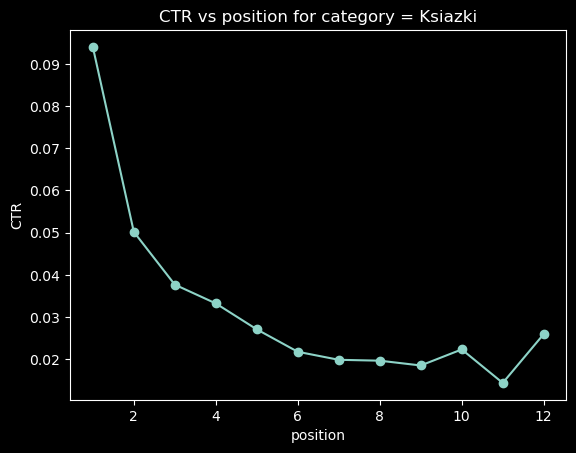

In [9]:
# category_match
df["category_match"] = (df["category"] == df["user_preferred_category"]).astype(int)

# CTR vs position for match/no-match
ctr_pos_match = df[df["category_match"] == 1].groupby("position")["clicked"].mean().sort_index()
ctr_pos_nomatch = df[df["category_match"] == 0].groupby("position")["clicked"].mean().sort_index()

plt.figure()
ctr_pos_match.plot(kind="line", marker="o", label="match=1")
ctr_pos_nomatch.plot(kind="line", marker="o", label="match=0")
plt.title("CTR vs position by category_match")
plt.xlabel("position")
plt.ylabel("CTR")
plt.legend()
plt.show()

# CTR vs position by category
for cat in df["category"].dropna().unique():
    tmp = df[df["category"] == cat].groupby("position")["clicked"].mean().sort_index()
    plt.figure()
    tmp.plot(kind="line", marker="o")
    plt.title(f"CTR vs position for category = {cat}")
    plt.xlabel("position")
    plt.ylabel("CTR")
    plt.show()

## 5) Price & quality: non-linear effects and interactions

/var/folders/v6/xzrdvw71737cqqc8m_0c1s1w0000gp/T/ipykernel_43798/369679305.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ctr_by_price = df.groupby("price_bucket")["clicked"].mean()
/var/folders/v6/xzrdvw71737cqqc8m_0c1s1w0000gp/T/ipykernel_43798/369679305.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ctr_by_quality = df.groupby("quality_bucket")["clicked"].mean()


,CTR
price_bucket,
"(5.539, 77.55]",0.084503
"(77.55, 115.04]",0.073192
"(115.04, 152.78]",0.075103
"(152.78, 194.29]",0.078185
"(194.29, 244.84]",0.072590
"(244.84, 308.24]",0.077446
"(308.24, 391.81]",0.074956
"(391.81, 523.02]",0.077594
"(523.02, 775.46]",0.075103


,CTR
quality_bucket,
"(0.099, 0.196]",0.031884
"(0.196, 0.285]",0.046129
"(0.285, 0.364]",0.049050
"(0.364, 0.434]",0.052670
"(0.434, 0.501]",0.067824
"(0.501, 0.568]",0.075307
"(0.568, 0.639]",0.088833
"(0.639, 0.715]",0.102375
"(0.715, 0.806]",0.119744


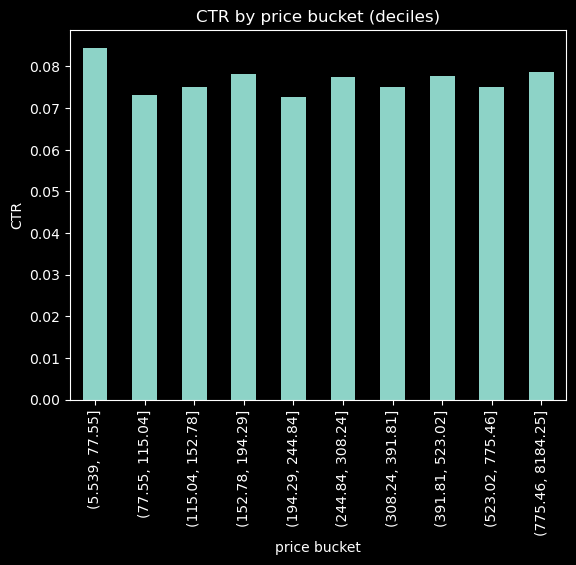

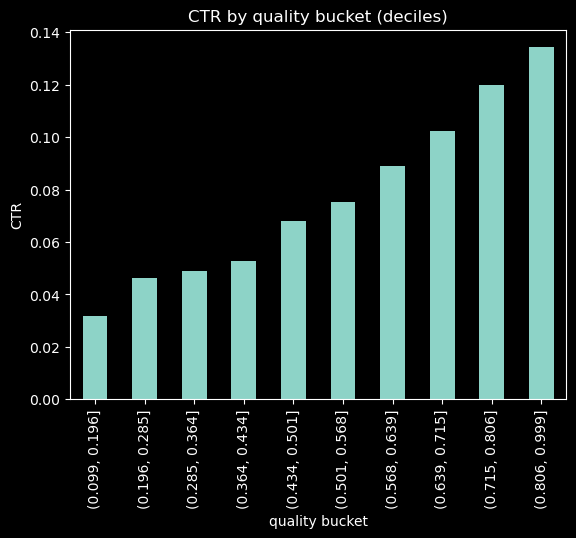

/var/folders/v6/xzrdvw71737cqqc8m_0c1s1w0000gp/T/ipykernel_43798/369679305.py:35: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index="price_bucket", columns="quality_bucket", values="clicked", aggfunc="mean")


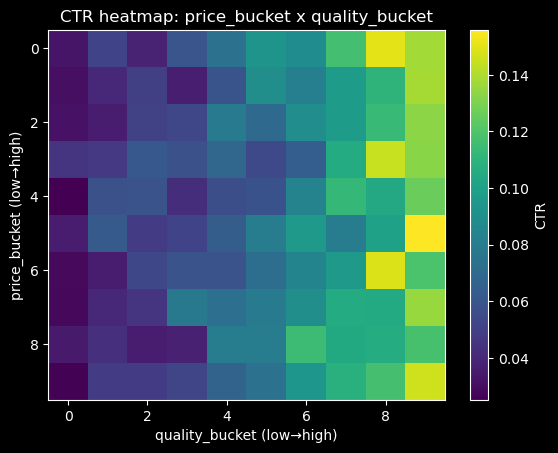

In [10]:
# Bucketing helpers
def qcut_safe(s, q=10):
    s = s.copy()
    # if too few unique values, fallback to cut
    if s.nunique(dropna=True) < q:
        return pd.cut(s, bins=min(q, s.nunique(dropna=True)), duplicates='drop')
    return pd.qcut(s, q=q, duplicates='drop')

df["price_bucket"] = qcut_safe(df["price_pln"].astype(float), q=10)
df["quality_bucket"] = qcut_safe(df["quality_score"].astype(float), q=10)

ctr_by_price = df.groupby("price_bucket")["clicked"].mean()
ctr_by_quality = df.groupby("quality_bucket")["clicked"].mean()

display(ctr_by_price.to_frame("CTR").head(20))
display(ctr_by_quality.to_frame("CTR").head(20))

plt.figure()
ctr_by_price.plot(kind="bar")
plt.title("CTR by price bucket (deciles)")
plt.xlabel("price bucket")
plt.ylabel("CTR")
plt.xticks(rotation=90)
plt.show()

plt.figure()
ctr_by_quality.plot(kind="bar")
plt.title("CTR by quality bucket (deciles)")
plt.xlabel("quality bucket")
plt.ylabel("CTR")
plt.xticks(rotation=90)
plt.show()

# Interaction heatmap: price_bucket x quality_bucket -> CTR
pivot = df.pivot_table(index="price_bucket", columns="quality_bucket", values="clicked", aggfunc="mean")
plt.figure()
plt.imshow(pivot.values, aspect="auto")
plt.title("CTR heatmap: price_bucket x quality_bucket")
plt.xlabel("quality_bucket (low→high)")
plt.ylabel("price_bucket (low→high)")
plt.colorbar(label="CTR")
plt.show()

## 6) Preference analysis: user_preferred_category vs clicked category

P(click in preferred category): 0.900211905220574


category,Elektronika,Ksiazki,Odziez
user_preferred_category,,,
Elektronika,0.132115,0.024364,0.045063
Ksiazki,0.065862,0.040036,0.048436
Odziez,0.070996,0.019823,0.075810


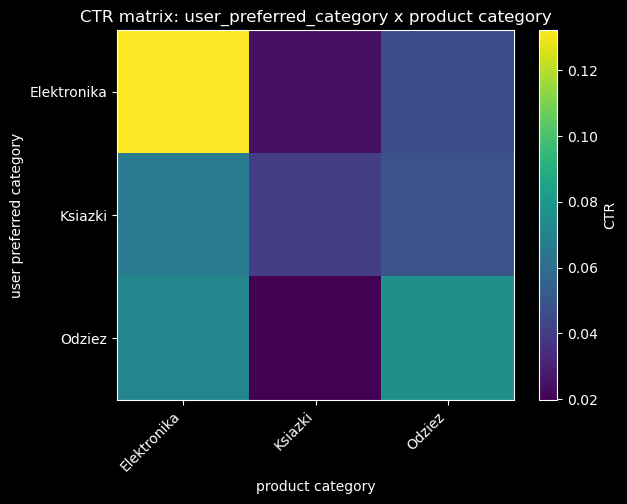

In [11]:
# How often clicks are in preferred category
clicked_rows = df[df["clicked"] == 1].copy()
clicked_rows["clicked_in_preferred"] = (clicked_rows["category"] == clicked_rows["user_preferred_category"]).astype(int)
if len(clicked_rows):
    print("P(click in preferred category):", float(clicked_rows["clicked_in_preferred"].mean()))

# Confusion-like table: user preferred vs product category CTR
pref_matrix = df.pivot_table(index="user_preferred_category", columns="category", values="clicked", aggfunc="mean")
display(pref_matrix)

plt.figure()
plt.imshow(pref_matrix.values, aspect="auto")
plt.title("CTR matrix: user_preferred_category x product category")
plt.xlabel("product category")
plt.ylabel("user preferred category")
plt.colorbar(label="CTR")
plt.xticks(range(len(pref_matrix.columns)), pref_matrix.columns, rotation=45, ha="right")
plt.yticks(range(len(pref_matrix.index)), pref_matrix.index)
plt.show()

## 7) Feature gaps and what you can engineer from existing columns

### High-impact missing features (engineerable from this dataset)

**Session-relative features (usually the biggest LTR lift):**
- `price_rank_in_session`, `price_percentile_in_session`, `price_minus_session_median`
- `quality_rank_in_session`, `quality_minus_session_mean`
- `session_size` (items per session)

**Count/context features:**
- `num_same_category_in_session`
- `is_majority_category` (product category == dominant category in session)

**Interaction features:**
- `quality_x_match = quality_score * category_match`
- `log_price_x_match = log_price * category_match`
- `quality_x_log_price = quality_score / (log_price + eps)` (variant)


In [12]:
# Base feature engineering required by the task
eps = 1e-6
df_fe = df.copy()
df_fe["position_boost"] = 1.0 / df_fe["position"].astype(float)
df_fe["log_price"] = np.log(df_fe["price_pln"].astype(float) + 1.0)
df_fe["quality_price_ratio"] = df_fe["quality_score"].astype(float) / (df_fe["log_price"].replace(0.0, eps))
df_fe["category_match"] = (df_fe["category"] == df_fe["user_preferred_category"]).astype(int)

# Additional interaction
df_fe["quality_x_match"] = df_fe["quality_score"].astype(float) * df_fe["category_match"].astype(float)

# Session-relative: price
df_fe["session_size"] = df_fe.groupby("session_id")["product_id"].transform("size")

df_fe["price_rank_in_session"] = df_fe.groupby("session_id")["price_pln"].rank(method="average", ascending=True)
df_fe["price_pct_in_session"] = df_fe["price_rank_in_session"] / (df_fe["session_size"].replace(0, 1))

df_fe["price_median_in_session"] = df_fe.groupby("session_id")["price_pln"].transform("median")
df_fe["price_minus_session_median"] = df_fe["price_pln"] - df_fe["price_median_in_session"]

# Session-relative: quality
df_fe["quality_rank_in_session"] = df_fe.groupby("session_id")["quality_score"].rank(method="average", ascending=True)
df_fe["quality_pct_in_session"] = df_fe["quality_rank_in_session"] / (df_fe["session_size"].replace(0, 1))

df_fe["quality_mean_in_session"] = df_fe.groupby("session_id")["quality_score"].transform("mean")
df_fe["quality_minus_session_mean"] = df_fe["quality_score"] - df_fe["quality_mean_in_session"]

# Context counts
df_fe["num_same_category_in_session"] = df_fe.groupby(["session_id","category"])["product_id"].transform("size")

# Majority category in session
majority_cat = df_fe.groupby(["session_id","category"]).size().reset_index(name="cnt")
majority_cat["max_cnt"] = majority_cat.groupby("session_id")["cnt"].transform("max")
majority_cat["is_majority"] = (majority_cat["cnt"] == majority_cat["max_cnt"]).astype(int)
df_fe = df_fe.merge(majority_cat[["session_id","category","is_majority"]], on=["session_id","category"], how="left")
df_fe["is_majority"] = df_fe["is_majority"].fillna(0).astype(int)

df_fe[[ "session_id","product_id","clicked",
       "position_boost","log_price","quality_price_ratio","category_match","quality_x_match",
       "price_pct_in_session","quality_pct_in_session","num_same_category_in_session","is_majority"
     ]].head()

,session_id,product_id,clicked,position_boost,log_price,quality_price_ratio,category_match,quality_x_match,price_pct_in_session,quality_pct_in_session,num_same_category_in_session,is_majority
0,0,prod_0_1,1,1.000000,3.714791,0.097717,1,0.363,0.090909,0.272727,9,1
1,0,prod_0_2,0,0.500000,5.523978,0.099023,1,0.547,0.454545,0.545455,9,1
2,0,prod_0_3,0,0.333333,6.522372,0.106710,1,0.696,0.909091,0.818182,9,1
3,0,prod_0_4,0,0.250000,6.203304,0.016120,1,0.100,0.545455,0.090909,9,1
4,0,prod_0_5,0,0.200000,8.000816,0.047995,0,0.000,1.000000,0.363636,1,0


## 8) Baseline rankers and offline NDCG@5 (sanity checks)

In [13]:
def ndcg_at_k(y_true, y_score, group_ids, k=5):
    gdf = pd.DataFrame({"g": group_ids, "y": y_true, "s": y_score})
    ndcgs = []
    for _, part in gdf.groupby("g", sort=False):
        part = part.sort_values("s", ascending=False)
        rel = part["y"].to_numpy()[:k]
        gains = (2**rel - 1)
        discounts = np.log2(np.arange(2, rel.size + 2))
        dcg = (gains / discounts).sum()
        ideal = np.sort(part["y"].to_numpy())[::-1][:k]
        igains = (2**ideal - 1)
        idcg = (igains / discounts[:ideal.size]).sum()
        ndcgs.append(0.0 if idcg == 0 else float(dcg / idcg))
    return float(np.mean(ndcgs)) if ndcgs else 0.0

# Prepare baseline scores per row
baseline_scores = {
    "position_boost_only": df_fe["position_boost"].to_numpy(),
    "quality_only": df_fe["quality_score"].astype(float).to_numpy(),
    "cheapness_only": (-df_fe["price_pln"].astype(float)).to_numpy(),  # lower price -> higher score
    "match_only": df_fe["category_match"].astype(float).to_numpy(),
    "quality_price_ratio": df_fe["quality_price_ratio"].astype(float).to_numpy(),
}

y = df_fe["clicked"].astype(int).to_numpy()
g = df_fe["session_id"].to_numpy()

baseline_ndcg = {name: ndcg_at_k(y, score, g, k=5) for name, score in baseline_scores.items()}
display(pd.Series(baseline_ndcg).sort_values(ascending=False).to_frame("NDCG@5"))

,NDCG@5
position_boost_only,0.292167
match_only,0.288015
quality_only,0.247124
quality_price_ratio,0.244290
cheapness_only,0.189763


## 9) Next steps (modeling improvements checklist)

### Modeling improvement checklist

1. **Split by `session_id` only** (no leakage).
2. Train a ranker with **session-relative features** (they often move NDCG the most).
3. Run **ablation tests**:
   - with `position_boost`
   - without `position_boost`
4. Evaluate NDCG@5:
   - overall
   - only sessions with >=1 click (diagnostic)
   - by category / by match / by session type (clicked position bucket)
5. Tune LightGBM:
   - `num_leaves`, `min_data_in_leaf`, `n_estimators`, `learning_rate`
6. Inspect feature importance and check if the model is dominated by `position_boost`.
